# Lasso on the IBLI dataset

In this notebook, I will be using a Lasso Cross Validation model, and a Group Lasso model on the IBLI dataset

In [84]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

# Load and preprocess the data

In [85]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/goat_df.xlsx")
df.head()

,Unnamed: 0,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,...,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip,ratio_insured_goat
0,0,1,4,No,25,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes,0.0
1,1,2,4,Yes,27,Yes,No,Adult Education,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
2,2,3,4,Yes,29,No,No,Elementary,No,1,...,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
3,3,4,4,No,35,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
4,4,5,4,No,36,Yes,No,Never attended,No,1,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes,0.0


In [86]:
#Agreement has been made to drop the ratio column from this dataset since it introduces endogeneity

df = df.drop(['Unnamed: 0','advise_vip','purchase_bin','cs_cs_ratio_post_goat','buy_nr_goat','buy_goat', 'ratio_insured_goat', 'n_previd_goat', 'wave', 'id'], axis=1)
columns_list = df.columns.tolist()
print(columns_list)

['afm_language', 'age_constant', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'expend', 'irrigated_land_bin', 'cs_cs_diff_post_goat', 'number_minors', 'educ_child_recoded', 'activity_child_recoded', 'household_description', 'number_adults', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip']


In [87]:
#Log+1 transforming the dataset to improve the distribution

df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_goat']) + 1)
df[['cs_cs_diff_post_goat', 'cs_diff_log']].head()

,cs_cs_diff_post_goat,cs_diff_log
0,-120.671875,4.801328
1,-758.621033,6.632820
2,-1180.266846,7.074343
3,-53.165897,3.992052
4,-513.432312,6.243064


# Deploying the Lasso Model
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [88]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_goat'])

In [89]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [90]:
#Preprocess the pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical),
    
#Encode the categorical columns    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical)
])


In [91]:
#Create a Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_constant', 'expend',
                                                   'irrigated_land_bin',
                                                   'number_minors',
                                                   'number_adults',
                                                   'owns_phone']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['afm_language', 'agric_land',
                                                   'amh_language',
                                                   'educ_recoded_constant',
                                                   'eng_language',
                                                   'educ_child_recoded',
                                                   'activity_child_recoded',
                                                   'household_description',
                                                   'main_info_source_recoded',
                                                   'religion_recoded',
                                                   'household_moved',
                                                   'why_not_purchase_recoded',
                                                   'know_vip',
                                                   'trust_vip'])])),
                ('lasso', LassoCV(cv=5, random_state=42))])

# Results

In [93]:
y_pred = lasso_pipeline.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.011639791053420723
MSE: 2.2660968757034103


In [94]:
lasso_model = lasso_pipeline.named_steps['lasso']
coefficients = lasso_model.coef_
print("Number of non-zero coefficients:", np.sum(coefficients != 0))

Number of non-zero coefficients: 13


In [95]:
feature_names = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()

coef = lasso_pipeline.named_steps['lasso'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

#Remove the 0 coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

# Sort the coefficients
top_features = non_zero_coef_df.reindex(non_zero_coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(top_features.head(20))


                                              Feature   Coefficient
42  cat__why_not_purchase_recoded_Lack of Awarenes... -1.187141e-01
31  cat__main_info_source_recoded_Interpersonal So...  9.575792e-02
28  cat__household_description_Fully settled: The ...  8.493228e-02
39     cat__why_not_purchase_recoded_BOUGHT INSURANCE  7.130390e-02
45                                  cat__trust_vip_No -6.120911e-02
2                             num__irrigated_land_bin  5.184424e-02
0                                   num__age_constant -3.675421e-02
1                                         num__expend  3.172736e-02
5                                     num__owns_phone -2.827016e-02
3                                  num__number_minors -2.662270e-02
4                                  num__number_adults -2.197967e-02
14          cat__educ_recoded_constant_Never attended -2.779568e-03
46                                 cat__trust_vip_Yes  1.576378e-16


# Grid search with Cross Validation

In [96]:
from sklearn.model_selection import GridSearchCV

#Define the new pipeline
lasso_pipeline_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

#Define the grid
param_grid = {'lasso__alpha': [0.01,0.009,0.007,0.006,0.005]}

#Perform Grid Search

grid_search = GridSearchCV(lasso_pipeline_gs, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train,y_train)

print("Best alpha: ", grid_search.best_params_)
print("Best R²: ", grid_search.best_score_)

best_model = grid_search.best_estimator_



Best alpha:  {'lasso__alpha': 0.01}
Best R²:  0.0028076471347668218


In [97]:
lasso_mae_list = []
lasso_rmse_list = []
lasso_mse_list = []

for alpha in param_grid['lasso__alpha']:
    model = Pipeline(steps=[
        ('preprocessor', clone(preprocessor)),
        ('lasso', Lasso(alpha=alpha, max_iter=10000))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)

    lasso_mae_list.append(mae)
    lasso_rmse_list.append(rmse)
    lasso_mse_list.append(mse)

In [98]:
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test,y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Test R²: 0.0131
Test MAE: 1.1279


# Group Lasso
https://group-lasso.readthedocs.io/en/latest/index.html

For this Group Lasso, I will be grouping all of the dummy variables created by the encoding.

In [99]:
from group_lasso import GroupLasso

In [100]:
preprocessor_group = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical)
])
X_processed_group = preprocessor.fit_transform(X)

#Create the groups
group_list = []
group_id = 0

#create a group for each numerical value
for _ in numerical:
    group_list.append(group_id)
    group_id += 1

ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)

#Create a group for each categorical value and dummy
grouped_counts = {}
for feature in cat_feature_names:
    prefix = feature.split("_")[0]
    grouped_counts[prefix] = grouped_counts.get(prefix,0) + 1

for _, count in grouped_counts.items():
    group_list.extend([group_id] * count)
    group_id += 1

groups = np.array(group_list)
print(groups)

[ 0  1  2  3  4  5  6  6  7  7  8  8  9  9  9  9  9  9  9  9  9 10 10 11
 11 11 11 11 12 12 12 12 12 13 13 13 14 14 14 15 15 15 15 16 16 17 17]


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [102]:
group_lasso = GroupLasso(groups=groups, group_reg=0.005, l1_reg=0.05,
                         scale_reg="group_size", supress_warning=True, n_iter=1000)

group_lasso.fit(X_train, y_train)

y_pred = group_lasso.predict(X_test)

print("R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Number of non-zero coefficients:", np.sum(group_lasso.coef_ != 0))

R^2: -0.0020604844880669493
MSE: 2.297508653838359
Number of non-zero coefficients: 0


In [103]:
feature_names = df.drop('cs_diff_log', axis=1).columns

non_zero_indices = np.where(group_lasso.coef_ != 0)[0]

non_zero_features = [(feature_names[i], group_lasso.coef_[i]) for i in non_zero_indices]

non_zero_df = pd.DataFrame(non_zero_features, columns=["Feature", "Coefficient"])
non_zero_df = non_zero_df.sort_values(by="Coefficient", key=abs, ascending=False)

print(non_zero_df)


Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


# Grid search on Group Lasso

In [112]:
# Define the parameter grid

#Decides the penalty on groups
group_reg_values = [0.01, 0.05, 0.1,0.001 ,0.07] 

#Lasso penalty, decides penalty on individual features
l1_reg_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.0001]

best_score = -np.inf
best_params = None
results = []

In [113]:
X_train, X_val, y_train, y_val = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [114]:
# Manual grid search
for group_reg in group_reg_values:
    for l1_reg in l1_reg_values:
        model = GroupLasso(
            groups=groups,
            group_reg=group_reg,
            l1_reg=l1_reg,
            scale_reg="group_size",
            supress_warning=True,
            n_iter=1000
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = r2_score(y_val, y_pred) #Tuning the gridsearch on the r2 score
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)

        results.append({
            'group_reg': group_reg,
            'l1_reg': l1_reg,
            'r2_score': score,
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        })

        if score > best_score:
            best_score = score
            best_params = (group_reg, l1_reg)

In [115]:
print(f" Best R² Score: {best_score:.4f} with group_reg={best_params[0]}, l1_reg={best_params[1]}")

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="r2_score", ascending=False))

 Best R² Score: 0.0205 with group_reg=0.001, l1_reg=0.0001
    group_reg  l1_reg  r2_score       mse      rmse       mae
23      0.001  0.0001  0.020495  2.245795  1.498598  1.124384
18      0.001  0.0010  0.017838  2.251885  1.500628  1.125824
19      0.001  0.0050  0.010888  2.267820  1.505928  1.129016
20      0.001  0.0100  0.004067  2.283459  1.511112  1.133026
5       0.010  0.0001  0.001229  2.289965  1.513263  1.135102
0       0.010  0.0010  0.000996  2.290501  1.513440  1.135192
1       0.010  0.0050 -0.000395  2.293690  1.514493  1.136022
2       0.010  0.0100 -0.001651  2.296569  1.515443  1.136811
27      0.070  0.0500 -0.001966  2.297292  1.515682  1.136717
25      0.070  0.0050 -0.002060  2.297508  1.515753  1.136623
16      0.100  0.1000 -0.002060  2.297508  1.515753  1.136623
26      0.070  0.0100 -0.002060  2.297508  1.515753  1.136623
7       0.050  0.0050 -0.002060  2.297508  1.515753  1.136623
3       0.010  0.0500 -0.002060  2.297508  1.515753  1.136623
12      0.1

## Visualisations for comparison

In [116]:
lasso_results_df = pd.DataFrame(grid_search.cv_results_)
lasso_results_df = lasso_results_df[['param_lasso__alpha', 'mean_test_score']]
lasso_results_df.columns = ['l1_reg', 'r2_score']
lasso_results_df['mae'] = lasso_mae_list
lasso_results_df['mse'] = lasso_mse_list
lasso_results_df['rmse'] = lasso_rmse_list

group_lasso_results_df = pd.DataFrame(results)

lasso_results_df['model'] = 'Lasso'
group_lasso_results_df['model'] = 'Group Lasso'

combined_results = pd.concat([lasso_results_df, group_lasso_results_df], ignore_index=True)

In [117]:
combined_results_sorted = combined_results.sort_values(by='r2_score', ascending=False)

styled_table = combined_results_sorted.style\
    .background_gradient(subset=['r2_score'], cmap='Greens')\
    .format({'l1_reg': '{:.2e}', 'r2_score': '{:.4f}'})\
    .set_caption("Comparing Lasso and Group Lasso R² Scores")

styled_table


,l1_reg,r2_score,mae,mse,rmse,model,group_reg
28,1.00e-04,0.0205,1.124384,2.245795,1.498598,Group Lasso,0.001000
23,1.00e-03,0.0178,1.125824,2.251885,1.500628,Group Lasso,0.001000
24,5.00e-03,0.0109,1.129016,2.267820,1.505928,Group Lasso,0.001000
25,1.00e-02,0.0041,1.133026,2.283459,1.511112,Group Lasso,0.001000
0,1.00e-02,0.0028,1.127882,2.262664,1.504216,Lasso,nan
1,9.00e-03,0.0027,1.127487,2.260369,1.503452,Lasso,nan
2,7.00e-03,0.0023,1.126877,2.256976,1.502323,Lasso,nan
3,6.00e-03,0.0020,1.126772,2.256040,1.502012,Lasso,nan
4,5.00e-03,0.0014,1.126569,2.255023,1.501674,Lasso,nan
10,1.00e-04,0.0012,1.135102,2.289965,1.513263,Group Lasso,0.010000


## Feature Importance visualization

Beste model prestaties op testset:
R^2: 0.020494408826323696
MSE: 2.245795146142576
Aantal niet-nul coëfficiënten: 41


C:\Users\daanm\AppData\Local\Temp\ipykernel_18752\3709989146.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="viridis")
C:\Users\daanm\AppData\Local\Temp\ipykernel_18752\3709989146.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


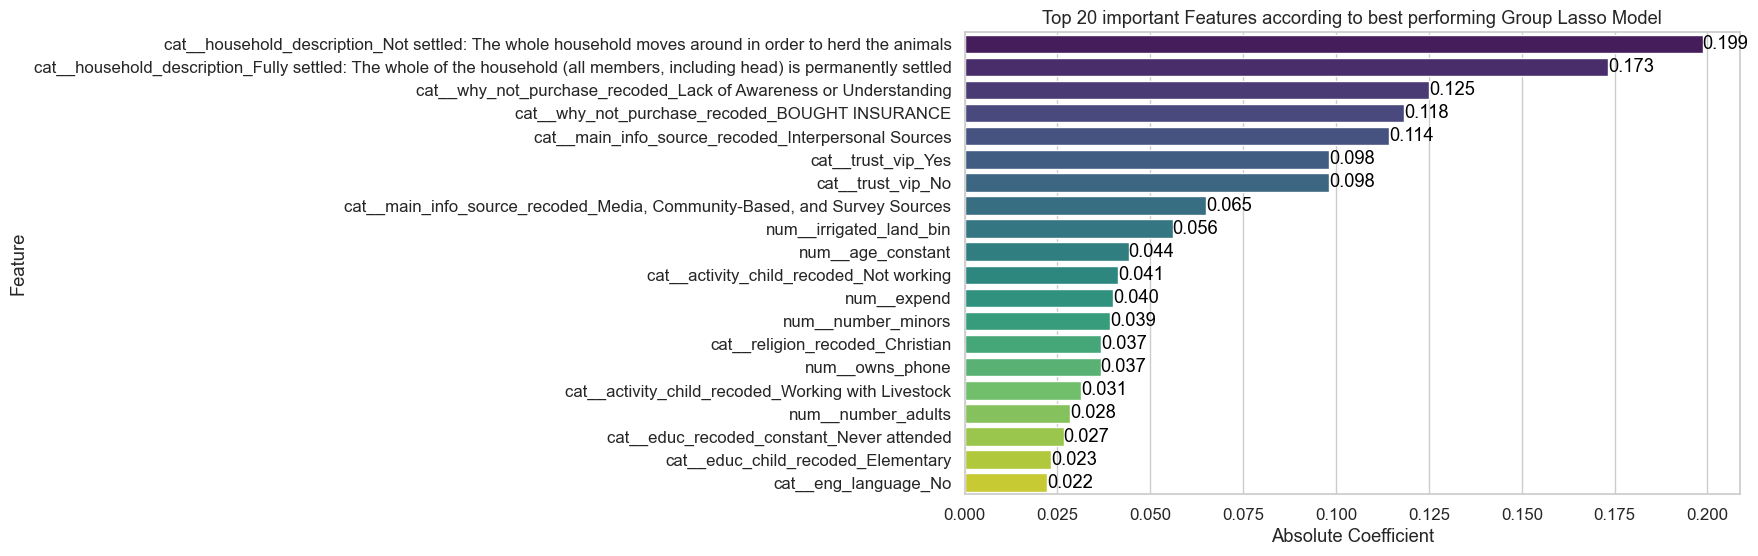

In [122]:
# Retrain the best model to get features
best_group_lasso = GroupLasso(
    groups=groups,
    group_reg=0.001,
    l1_reg=0.0001,
    scale_reg="group_size",
    supress_warning=True,
    n_iter=1000
)

best_group_lasso.fit(X_train, y_train)

# Predict
y_pred = best_group_lasso.predict(X_test)

# Get feature names
feature_names = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_group_lasso.coef_.ravel()  # 1D maken

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute Coefficient": np.abs(coefficients)
})

coef_df = coef_df[coef_df["Coefficient"] != 0]
top_features_df = coef_df.sort_values(by="Absolute Coefficient", ascending=False).head(20)


#Plot figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="viridis")
plt.title("Top 20 important Features according to best performing Group Lasso Model")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")

for i, value in enumerate(top_features_df["Absolute Coefficient"]):
    ax.text(value, i, f'{value:.3f}', color='black', va='center')

plt.tight_layout()
plt.savefig("top_features_best_group_lasso_v2.png", dpi=300)
plt.show()



In [1]:
#Summary of all models
sns.set(style="whitegrid")

data = {
    "Model": ["Lasso", "TabTransformers", "GRF", "BayesianRidge", 
              "Lasso", "TabTransformers", "GRF", "BayesianRidge"],
    "Dataset": ["Cattle", "Cattle", "Cattle", "Cattle", 
                "Goat", "Goat", "Goat", "Goat"],
    "R²": [0.011, -0.006, 0.006, -0.007, 0.021, 0.046, 0.011, 0.016],
    "MAE": [1.204, 1.286, 1.238, 1.203, 1.124, 1.056, 1.115, 1.127],
    "RMSE": [1.656, 1.783, 1.717, 1.655, 1.499, 1.412, 1.472, 1.502]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#R²
sns.barplot(x="Model", y="R²", hue="Dataset", data=df, ax=axes[0])
axes[0].set_title("R²-score comparison (Higher = better)")
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)

#MAE
sns.barplot(x="Model", y="MAE", hue="Dataset", data=df, ax=axes[1])
axes[1].set_title("MAE comparison (Lower = better)")

#RMSE
sns.barplot(x="Model", y="RMSE", hue="Dataset", data=df, ax=axes[2])
axes[2].set_title("RMSE comparison (Lower = better)")

for ax in axes:
    ax.set_xlabel("Model")
    ax.set_ylabel("")
    ax.legend_.set_title("Dataset")
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()


NameError: name 'sns' is not defined